<a href="https://colab.research.google.com/github/ashwinbh007/PROJECT-1/blob/main/PROJECT_1_CHURN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Data Loading

In [1]:
# @title 1. Install Libraries and Import Dependencies
!pip install scikit-learn pandas numpy matplotlib seaborn tensorflow imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE # For handling imbalanced data

# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

print("Libraries installed and imported successfully!")

Libraries installed and imported successfully!


In [2]:
# @title 2. Load the Dataset
# You can download the dataset directly from Kaggle or use the URL below.
# A common URL for the IBM Telco Customer Churn dataset:
# https://raw.githubusercontent.com/IBM/telco-customer-churn-prediction/master/WA_Fn-UseC_-Telco-Customer-Churn.csv

try:
    df = pd.read_csv('https://raw.githubusercontent.com/YBIFoundation/Dataset/refs/heads/main/TelecomCustomerChurn.csv')
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the URL is correct or upload the 'WA_Fn-UseC_-Telco-Customer-Churn.csv' file directly to Colab.")

Dataset loaded successfully!
Dataset shape: (7043, 21)

First 5 rows of the dataset:
   customerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

  MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0            No             DSL             No  ...               No   
1            No             DSL            Yes  ...              Yes   
2            No             DSL            Yes  ...               No   
3            No             DSL            Yes  ...              Yes   
4            No     Fiber optic             No  ...               No   

 

# Exploratory Data Analysis (EDA)

In [3]:
# @title 3. Initial Data Inspection

print("\nDataset Info:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nValue counts for 'Churn' column:")
print(df['Churn'].value_counts())
print(f"Churn percentage: {df['Churn'].value_counts(normalize=True)[1]*100:.2f}%")

# Convert 'TotalCharges' to numeric, coercing errors to NaN
# 'TotalCharges' is often stored as object due to empty strings
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print("\nMissing values after 'TotalCharges' conversion:")
print(df.isnull().sum())

# Handle missing 'TotalCharges' - usually a small number, fill with median
# or consider dropping if it's a significant portion.
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
print("\nMissing 'TotalCharges' handled (filled with median).")
print(df.isnull().sum().sum(), "total missing values remaining.")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-

/tmp/ipython-input-2514840402.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Churn percentage: {df['Churn'].value_counts(normalize=True)[1]*100:.2f}%")
/tmp/ipython-input-2514840402.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


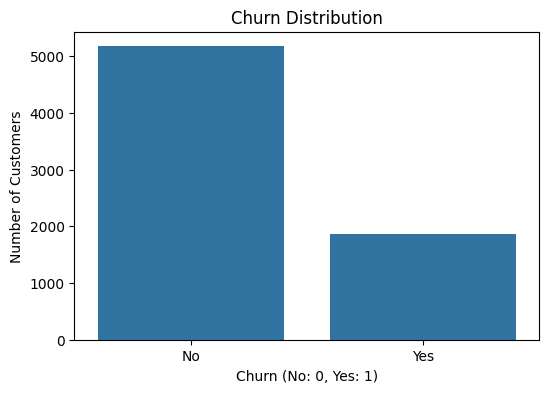

In [4]:
# @title 4. Visualize Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (No: 0, Yes: 1)')
plt.ylabel('Number of Customers')
plt.show()

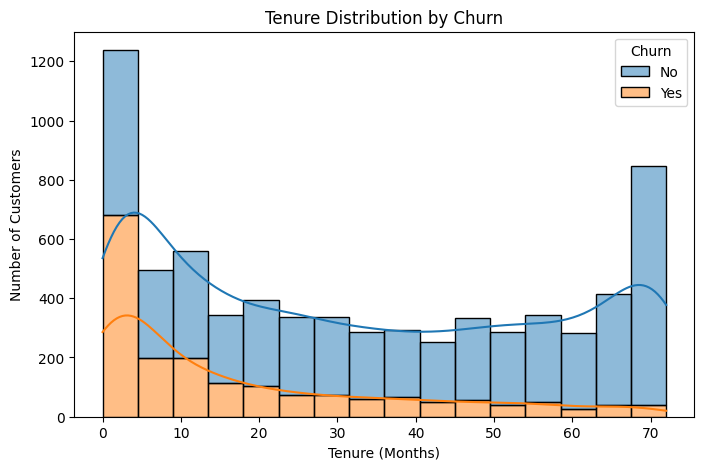

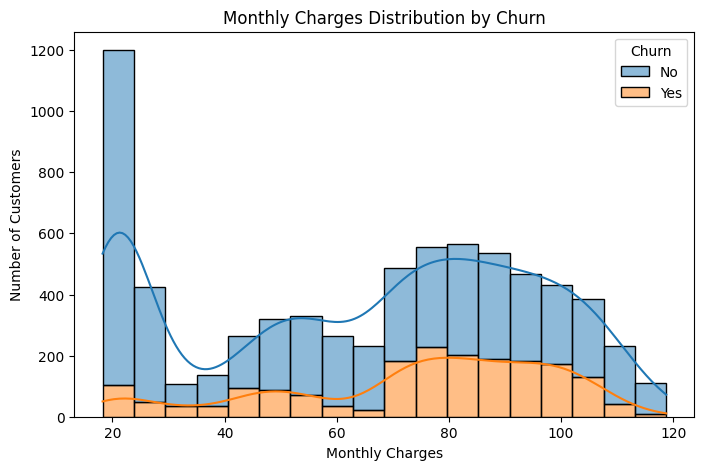

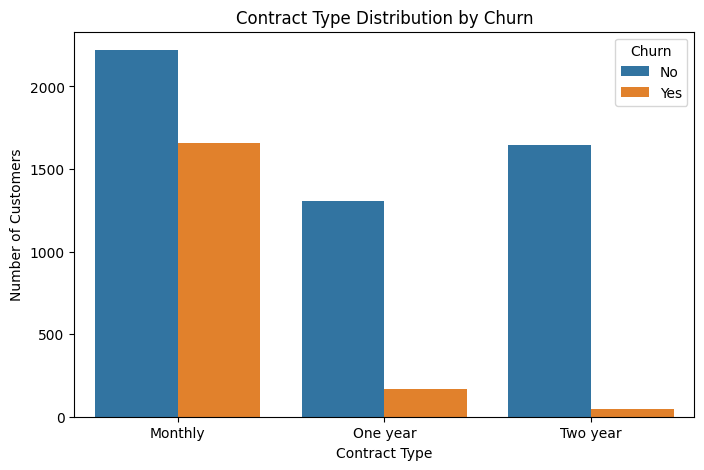

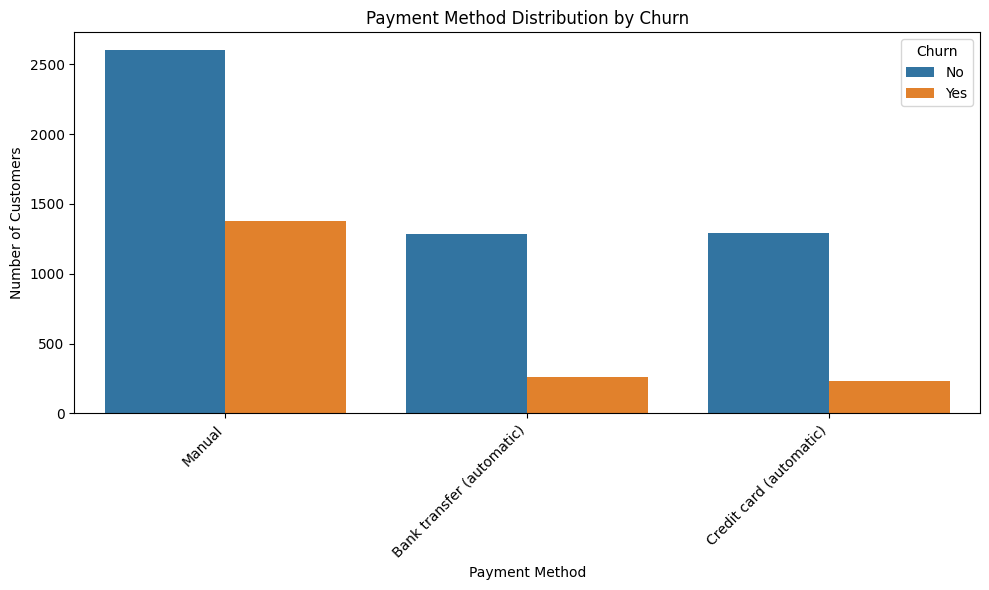

In [5]:
# @title 5. Feature Relationships with Churn (Examples)

# Convert Churn to numerical for correlation calculation
df['Churn_numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Tenure vs Churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Tenure', hue='Churn', multiple='stack', kde=True)
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
plt.show()

# Monthly Charges vs Churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', kde=True)
plt.title('Monthly Charges Distribution by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Number of Customers')
plt.show()

# Contract Type vs Churn
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract Type Distribution by Churn')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()

# Payment Method vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.title('Payment Method Distribution by Churn')
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Drop the temporary 'Churn_numeric' column
df.drop('Churn_numeric', axis=1, inplace=True)

# Data Preprocessing

In [6]:
# @title 6. Define Features and Target
# Drop customerID as it's just an identifier and won't be used for prediction
df_processed = df.drop('customerID', axis=1)

# Define target variable
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) # Convert 'Yes'/'No' to 1/0

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print(f"Categorical columns: {list(categorical_cols)}")
print(f"Numerical columns: {list(numerical_cols)}")

Categorical columns: ['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges']


In [8]:
# @title 7. Create Preprocessing Pipelines
# Create a column transformer for preprocessing
# Numerical features will be scaled
# Categorical features will be One-Hot Encoded

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep other columns if any, though not expected here
)

print("Preprocessing pipeline created.")

# @title 8. Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to maintain churn ratio

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nChurn distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nChurn distribution in test set:")
print(y_test.value_counts(normalize=True))

Preprocessing pipeline created.
X_train shape: (5634, 19)
X_test shape: (1409, 19)
y_train shape: (5634,)
y_test shape: (1409,)

Churn distribution in training set:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Churn distribution in test set:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


In [9]:
# @title 9. Handle Class Imbalance using SMOTE
# Apply preprocessing to training data before SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE only to the processed training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)


# Convert to dense numpy arrays if they are sparse matrices
X_train_resampled = X_train_resampled.toarray() if hasattr(X_train_resampled, 'toarray') else X_train_resampled
X_test_processed = X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed


print(f"\nShape of X_train_resampled after SMOTE: {X_train_resampled.shape}")
print(f"Shape of y_train_resampled after SMOTE: {y_train_resampled.shape}")
print("\nChurn distribution in resampled training set:")
print(y_train_resampled.value_counts(normalize=True))


print(f"\nFinal X_train_processed shape: {X_train_resampled.shape}")
print(f"Final X_test_processed shape: {X_test_processed.shape}")


Shape of X_train_resampled after SMOTE: (8278, 37)
Shape of y_train_resampled after SMOTE: (8278,)

Churn distribution in resampled training set:
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

Final X_train_processed shape: (8278, 37)
Final X_test_processed shape: (1409, 37)


# Artificial Neural Network (ANN) Model Development

In [10]:
# @title 10. Build the ANN Model

# Determine the number of features after preprocessing
input_shape = X_train_resampled.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)), # Input layer and first hidden layer
    Dense(64, activation='relu'),                               # Second hidden layer
    Dense(32, activation='relu'),                               # Third hidden layer
    Dense(1, activation='sigmoid')                              # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
print("\nANN model built and compiled.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,233 (59.50 KB)

 Trainable params: 15,233 (59.50 KB)

 Non-trainable params: 0 (0.00 B)


ANN model built and compiled.


In [11]:
# @title 11. Train the ANN Model

# Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_processed, y_train_resampled,
                    epochs=100, # Increased epochs, but early stopping will manage it
                    batch_size=32,
                    validation_split=0.2, # Use 20% of the training data for validation during training
                    callbacks=[early_stopping],
                    verbose=1)

print("\nANN model training complete.")

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7546 - loss: 0.5038 - val_accuracy: 0.7595 - val_loss: 0.4616
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8012 - loss: 0.4174 - val_accuracy: 0.7675 - val_loss: 0.4495
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8030 - loss: 0.4096 - val_accuracy: 0.7657 - val_loss: 0.4503
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8063 - loss: 0.4063 - val_accuracy: 0.7684 - val_loss: 0.4500
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8096 - loss: 0.4024 - val_accuracy: 0.7675 - val_loss: 0.4515
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8114 - loss: 0.3996 - val_accuracy: 0.7684 - val_loss: 0.4532
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8146 - loss: 0.3961 - val_accuracy: 0.7684 - val_loss: 0.4547
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8165 - loss: 0.3924 - val_accu

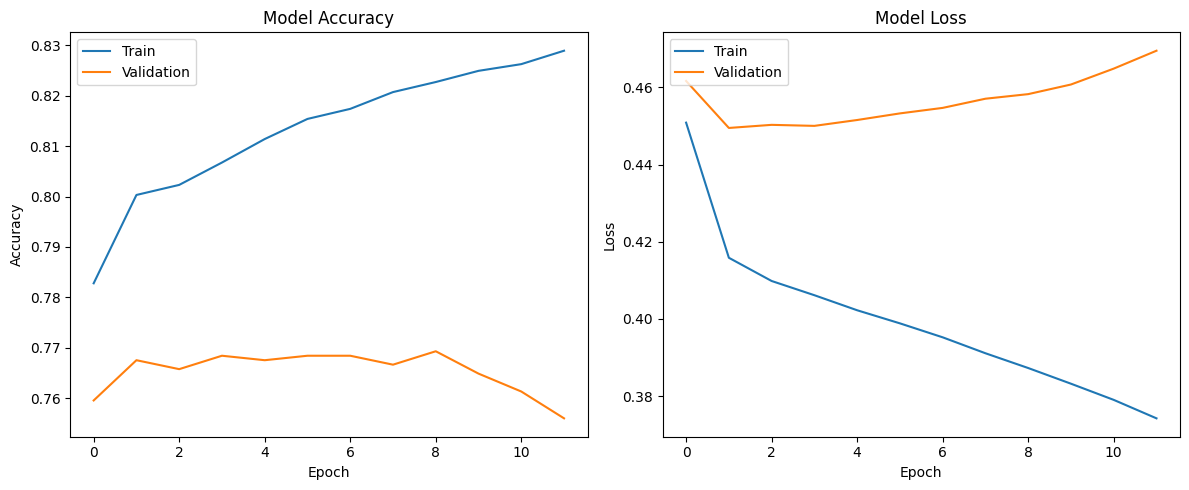

In [12]:
# @title 12. Visualize Training History (Loss and Accuracy)
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Model Evaluation


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model Evaluation on Test Set:
Accuracy: 0.7807
F1-score: 0.6033

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.86      0.84      0.85      1035
       Churn       0.58      0.63      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.73      1409
weighted avg       0.79      0.78      0.78      1409



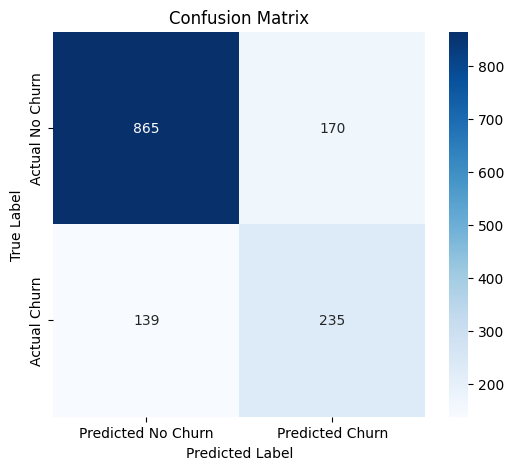

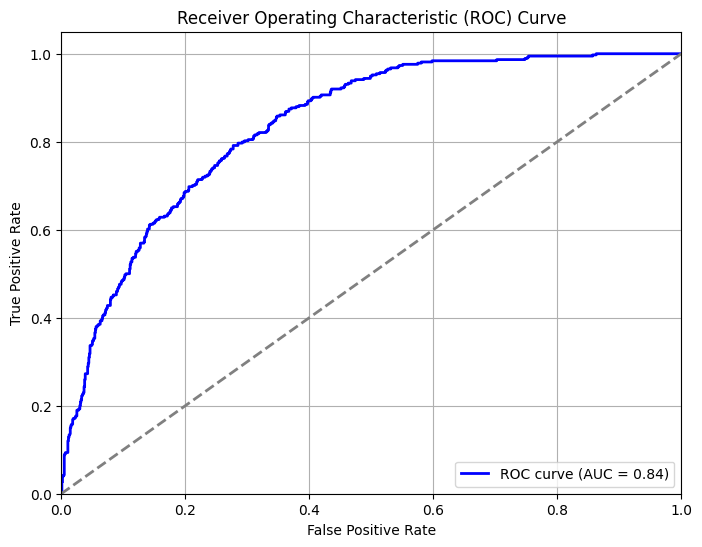

In [13]:
# @title 13. Evaluate Model Performance

# Predict probabilities on the test set
y_pred_proba = model.predict(X_test_processed)
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions (0 or 1)

print("\nModel Evaluation on Test Set:")

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC AUC Curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Generate List of At-Risk Customers

In [14]:
# @title 14. Predict Churn for All Customers and Identify At-Risk Customers

# Use the preprocessor to transform the entire original dataset (excluding 'customerID' and 'Churn')
X_all_processed = preprocessor.transform(X)

# Predict churn probabilities for all customers
all_churn_probabilities = model.predict(X_all_processed)

# Add probabilities to the original DataFrame for analysis
df['Churn_Probability'] = all_churn_probabilities

# Define a churn probability threshold (e.g., > 0.5 or adjust based on business needs and ROC curve)
churn_threshold = 0.5 # You can fine-tune this based on the recall/precision trade-off desired

at_risk_customers = df[df['Churn_Probability'] >= churn_threshold].copy()
at_risk_customers = at_risk_customers.sort_values(by='Churn_Probability', ascending=False)

print(f"\nNumber of potential at-risk customers (probability >= {churn_threshold}): {len(at_risk_customers)}")

print("\nTop 20 At-Risk Customers (ordered by churn probability):")
# Display customerID along with relevant features and churn probability
# Note: customerID was dropped for training, so we need to merge it back or keep it aside
# For simplicity, we'll just display features from the original df and use the original customerID index.
# Make sure customerID is still in df if you want to display it.
# Assuming 'customerID' was the index or a column in original 'df'.
# Let's re-add customerID to 'df' from the very start if it was removed earlier.
# If customerID was never dropped from 'df' (only from 'X'), then it's fine.

# If you want customerID in the output:
# Ensure df_original = pd.read_csv(...) is kept, and df is a copy if modified
# Or, keep customerID in 'df' until this step and then extract it.
# For now, assuming df contains 'customerID' for display:

if 'customerID' in at_risk_customers.columns:
    print(at_risk_customers[['customerID', 'Tenure', 'MonthlyCharges', 'Contract', 'Churn_Probability', 'Churn']].head(20).to_string())
else:
    # If customerID was truly removed early, we can't show it here.
    # Re-run the data loading and keep customerID if needed for this output.
    print(at_risk_customers[['Tenure', 'MonthlyCharges', 'Contract', 'Churn_Probability', 'Churn']].head(20).to_string())


# You can save this list to a CSV for ConnectSphere Telecom
# at_risk_customers[['customerID', 'Churn_Probability']].to_csv('at_risk_customers.csv', index=False)
# print("\nList of at-risk customers saved to 'at_risk_customers.csv'")

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Number of potential at-risk customers (probability >= 0.5): 1992

Top 20 At-Risk Customers (ordered by churn probability):
      customerID  Tenure  MonthlyCharges Contract  Churn_Probability Churn
4800  9300-AGZNL       1           94.00  Monthly           0.852836   Yes
1976  9497-QCMMS       1           93.55  Monthly           0.852629   Yes
6368  2720-WGKHP       2           94.00  Monthly           0.850045   Yes
3749  4424-TKOPW       2           93.85  Monthly           0.849797   Yes
4585  1069-XAIEM       1           85.05  Monthly           0.849099   Yes
1410  7024-OHCCK       2           93.85  Monthly           0.848312   Yes
3159  5150-ITWWB       3           94.85  Monthly           0.846848    No
2208  7216-EWTRS       1          100.80  Monthly           0.846554   Yes
3346  2545-EBUPK       2           84.05  Monthly           0.845490    No
301   8098-LLAZX       4           95.45  Monthly           0.843469   Yes
997   1374